In [1]:
# Building simplest autoencoder

# start simple, with a single fully-connected neural layer as encoder and as decoder:

In [2]:
# import keras
# from keras import layers

# # This is the size of our encoded representations
# encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# # This is our input image
# input_img = keras.Input(shape=(784,))
# # "encoded" is the encoded representation of the input
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# # "decoded" is the lossy reconstruction of the input
# decoded = layers.Dense(784, activation='sigmoid')(encoded)

# # This model maps an input to its reconstruction
# autoencoder = keras.Model(input_img, decoded)

In [3]:
# # This model maps an input to its encoded representation
# encoder = keras.Model(input_img, encoded)

In [4]:
# # This is our encoded (32-dimensional) input
# encoded_input = keras.Input(shape=(encoding_dim,))
# # Retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # Create the decoder model
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [5]:
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
# # preparing input data using MNIST digits, 
# # and we're discarding the labels (since we're only interested in encoding/decoding the input images).
# from keras.datasets import mnist
# import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

In [7]:
# # Normalise values between 0 and 1 and flatten the 28x28 images into vectors, size 784 
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print(x_train.shape)
# print(x_test.shape)

In [8]:
# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

In [9]:
# # Encode and decode some digits
# # Note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test)
# decoded_imgs = decoder.predict(encoded_imgs)

In [10]:
# # Use Matplotlib (don't ask)
# import matplotlib.pyplot as plt

# n = 10  # How many digits we will display
# plt.figure(figsize=(20, 4))
# for i in range(n):
#     # Display original
#     ax = plt.subplot(2, n, i + 1)
#     plt.imshow(x_test[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # Display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(decoded_imgs[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [11]:
# # Adding a sparsity constraint on the encoded representations

# from keras import regularizers

# encoding_dim = 32

# input_img = keras.Input(shape=(784,))
# # Add a Dense layer with a L1 activity regularizer
# encoded = layers.Dense(encoding_dim, activation='relu',
#                 activity_regularizer=regularizers.l1(10e-5))(input_img)
# decoded = layers.Dense(784, activation='sigmoid')(encoded)

# autoencoder = keras.Model(input_img, decoded)


In [12]:
# ----------------------------------------------------------------------
# 
# Convolutional Autoencoder

In [13]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [15]:

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

# from keras.callbacks import TensorBoard

# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_test, x_test),
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 48s 99ms/step - loss: 0.3047 - val_loss: 0.1457
Epoch 2/50
469/469 [==============================] - 44s 94ms/step - loss: 0.1406 - val_loss: 0.1263
Epoch 3/50
469/469 [==============================] - 43s 91ms/step - loss: 0.1243 - val_loss: 0.1167
Epoch 4/50
469/469 [==============================] - 43s 91ms/step - loss: 0.1161 - val_loss: 0.1115
Epoch 5/50
469/469 [==============================] - 42s 90ms/step - loss: 0.1116 - val_loss: 0.1083
Epoch 6/50
469/469 [==============================] - 42s 89ms/step - loss: 0.1086 - val_loss: 0.1063
Epoch 7/50
469/469 [==============================] - 42s 90ms/step - loss: 0.1065 - val_loss: 0.1041
Epoch 8/50
469/469 [==============================] - 42s 90ms/step - loss: 0.1048 - val_loss: 0.1026
Epoch 9/50
469/469 [==============================] - 43s 91ms/step - loss: 0.1035 - val_loss: 0.1016
Epoch 10/50
469/469 [==============================] - 42s 90ms/step - loss: 0.102

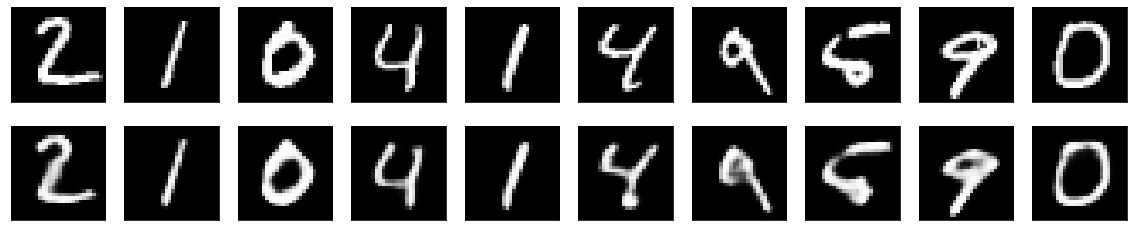

In [17]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

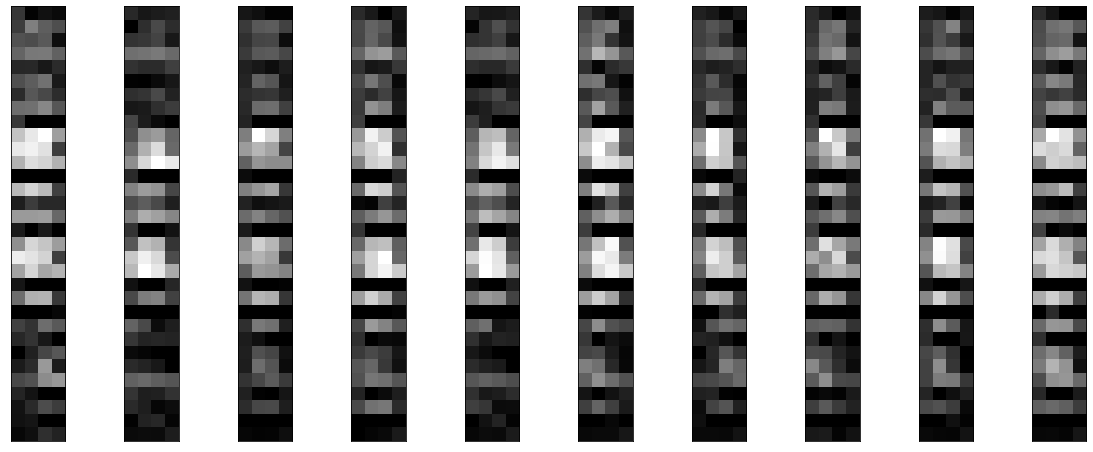

In [18]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()